### Data Summary
- ZTF DR14 source table
- ZTF DR14 catalog table
- Gaia DR3 catalog table

### Goals for Notebook
- All-sky selection of FG dwafs using LSDB (`main`)
- Run dip detection algorithm using TAPE (`main`)
- Save `.pq` file: 
    - Store ps1_id's 
    - Number of dips, dip infromation
    - Biweight $\sigma_{lc}$ and other Gaia metrics (i.e bp_rp, parallax,...)
 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})

In [2]:
%%time
#Load ZTF, Gaia, and ZTF sources hipscats # note data3/ for epyc
gaia = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic")

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

CPU times: user 1.69 s, sys: 193 ms, total: 1.88 s
Wall time: 1.89 s


In [3]:
%%time
# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

CPU times: user 31 s, sys: 1.98 s, total: 33 s
Wall time: 33 s


In [5]:
%%time
# crossmatch ZTF + Gaia
_all_sky_object = gaia.crossmatch(ztf).query(
    "nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    bp_rp_gaia > -99 and phot_g_mean_mag_gaia > 0 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5")
# ran at 4:28

CPU times: user 1.88 s, sys: 9.33 ms, total: 1.89 s
Wall time: 1.89 s


In [6]:
%%time
_all_sky_object = _all_sky_object.compute()

CPU times: user 1h 41min 4s, sys: 4h 6min 43s, total: 5h 47min 48s
Wall time: 1h 39min 34s


In [8]:
%%time 
# Convert crossmatch _sample to lsdb Catalog object
_sample_hips = lsdb.from_dataframe(
    _all_sky_object, 
    lowest_order=5, 
    highest_order=8, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia", 
    threshold=1_000_000
)

CPU times: user 6min 29s, sys: 9min 54s, total: 16min 24s
Wall time: 16min 27s


In [10]:
%%time
_sources = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

CPU times: user 1min 44s, sys: 1.01 s, total: 1min 45s
Wall time: 1min 45s


In [11]:
# lazy loading sources
_sources

,solution_id_gaia_,designation_gaia_,source_id_gaia_,random_index_gaia_,ref_epoch_gaia_,ra_gaia_,ra_error_gaia_,dec_gaia_,dec_error_gaia_,parallax_gaia_,parallax_error_gaia_,parallax_over_error_gaia_,pm_gaia_,pmra_gaia_,pmra_error_gaia_,pmdec_gaia_,pmdec_error_gaia_,ra_dec_corr_gaia_,ra_parallax_corr_gaia_,ra_pmra_corr_gaia_,ra_pmdec_corr_gaia_,dec_parallax_corr_gaia_,dec_pmra_corr_gaia_,dec_pmdec_corr_gaia_,parallax_pmra_corr_gaia_,parallax_pmdec_corr_gaia_,pmra_pmdec_corr_gaia_,astrometric_n_obs_al_gaia_,astrometric_n_obs_ac_gaia_,astrometric_n_good_obs_al_gaia_,astrometric_n_bad_obs_al_gaia_,astrometric_gof_al_gaia_,astrometric_chi2_al_gaia_,astrometric_excess_noise_gaia_,astrometric_excess_noise_sig_gaia_,astrometric_params_solved_gaia_,astrometric_primary_flag_gaia_,nu_eff_used_in_astrometry_gaia_,pseudocolour_gaia_,pseudocolour_error_gaia_,ra_pseudocolour_corr_gaia_,dec_pseudocolour_corr_gaia_,parallax_pseudocolour_corr_gaia_,pmra_pseudocolour_corr_gaia_,pmdec_pseudocolour_corr_gaia_,astrometric_matched_transits_gaia_,visibility_periods_used_gaia_,astrometric_sigma5d_max_gaia_,matched_transits_gaia_,new_matched_transits_gaia_,matched_transits_removed_gaia_,ipd_gof_harmonic_amplitude_gaia_,ipd_gof_harmonic_phase_gaia_,ipd_frac_multi_peak_gaia_,ipd_frac_odd_win_gaia_,ruwe_gaia_,scan_direction_strength_k1_gaia_,scan_direction_strength_k2_gaia_,scan_direction_strength_k3_gaia_,scan_direction_strength_k4_gaia_,scan_direction_mean_k1_gaia_,scan_direction_mean_k2_gaia_,scan_direction_mean_k3_gaia_,scan_direction_mean_k4_gaia_,duplicated_source_gaia_,phot_g_n_obs_gaia_,phot_g_mean_flux_gaia_,phot_g_mean_flux_error_gaia_,phot_g_mean_flux_over_error_gaia_,phot_g_mean_mag_gaia_,phot_bp_n_obs_gaia_,phot_bp_mean_flux_gaia_,phot_bp_mean_flux_error_gaia_,phot_bp_mean_flux_over_error_gaia_,phot_bp_mean_mag_gaia_,phot_rp_n_obs_gaia_,phot_rp_mean_flux_gaia_,phot_rp_mean_flux_error_gaia_,phot_rp_mean_flux_over_error_gaia_,phot_rp_mean_mag_gaia_,phot_bp_rp_excess_factor_gaia_,phot_bp_n_contaminated_transits_gaia_,phot_bp_n_blended_transits_gaia_,phot_rp_n_contaminated_transits_gaia_,phot_rp_n_blended_transits_gaia_,phot_proc_mode_gaia_,bp_rp_gaia_,bp_g_gaia_,g_rp_gaia_,radial_velocity_gaia_,radial_velocity_error_gaia_,rv_method_used_gaia_,rv_nb_transits_gaia_,rv_nb_deblended_transits_gaia_,rv_visibility_periods_used_gaia_,rv_expected_sig_to_noise_gaia_,rv_renormalised_gof_gaia_,rv_chisq_pvalue_gaia_,rv_time_duration_gaia_,rv_amplitude_robust_gaia_,rv_template_teff_gaia_,rv_template_logg_gaia_,rv_template_fe_h_gaia_,rv_atm_param_origin_gaia_,vbroad_gaia_,vbroad_error_gaia_,vbroad_nb_transits_gaia_,grvs_mag_gaia_,grvs_mag_error_gaia_,grvs_mag_nb_transits_gaia_,rvs_spec_sig_to_noise_gaia_,phot_variable_flag_gaia_,l_gaia_,b_gaia_,ecl_lon_gaia_,ecl_lat_gaia_,in_qso_candidates_gaia_,in_galaxy_candidates_gaia_,non_single_star_gaia_,has_xp_continuous_gaia_,has_xp_sampled_gaia_,has_rvs_gaia_,has_epoch_photometry_gaia_,has_epoch_rv_gaia_,has_mcmc_gspphot_gaia_,has_mcmc_msc_gaia_,in_andromeda_survey_gaia_,classprob_dsc_combmod_quasar_gaia_,classprob_dsc_combmod_galaxy_gaia_,classprob_dsc_combmod_star_gaia_,teff_gspphot_gaia_,teff_gspphot_lower_gaia_,teff_gspphot_upper_gaia_,logg_gspphot_gaia_,logg_gspphot_lower_gaia_,logg_gspphot_upper_gaia_,mh_gspphot_gaia_,mh_gspphot_lower_gaia_,mh_gspphot_upper_gaia_,distance_gspphot_gaia_,distance_gspphot_lower_gaia_,distance_gspphot_upper_gaia_,azero_gspphot_gaia_,azero_gspphot_lower_gaia_,azero_gspphot_upper_gaia_,ag_gspphot_gaia_,ag_gspphot_lower_gaia_,ag_gspphot_upper_gaia_,ebpminrp_gspphot_gaia_,ebpminrp_gspphot_lower_gaia_,ebpminrp_gspphot_upper_gaia_,libname_gspphot_gaia_,Norder_gaia_,Npix_gaia_,Dir_gaia_,ps1_objid_ztf_dr14_,ra_ztf_dr14_,dec_ztf_dr14_,ps1_gMeanPSFMag_ztf_dr14_,ps1_rMeanPSFMag_ztf_dr14_,ps1_iMeanPSFMag_ztf_dr14_,nobs_g_ztf_dr14_,nobs_r_ztf_dr14_,nobs_i_ztf_dr14_,mean_mag_g_ztf_dr14_,mean_mag_r_ztf_dr14_,mean_mag_i_ztf_dr14_,Norder_ztf_dr14_,Dir_ztf_dr14_,Npix_ztf_dr14_,_DIST_,Norder_,Dir_,Np

### TAPE

In [98]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

# Initialize an Ensemble
ens = Ensemble(memory_limit=1e11, n_workers=12)
ens.client_info()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38818 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38818/status,
Dashboard: http://127.0.0.1:38818/status,Workers: 12
Total threads: 72,Total memory: 1.09 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44149,Workers: 12
Dashboard: http://127.0.0.1:38818/status,Total threads: 72
Started: Just now,Total memory: 1.09 TiB
Comm: tcp://127.0.0.1:33668,Total threads: 6
Dashboard: http://127.0.0.1:33918/status,Memory: 93.13 GiB
Nanny: tcp://127.0.0.1:38451,


In [99]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

In [100]:
%%time
# We can read from parquet
ens.from_dask_dataframe(
    source_frame=_sources._ddf,
    object_frame=_sample_hips._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

CPU times: user 397 ms, sys: 10.4 ms, total: 407 ms
Wall time: 399 ms


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


### Dipper Detection Algorithm Prototype (DDAP)

In [101]:
# algorithm developed here: https://github.com/AndyTza/little-dip/blob/main/notebook/Prototype%20Algorithm.ipynb

from scipy.signal import find_peaks
import astropy.stats as astro_stats

def deviation(mag, mag_err):
    """Calculate the running deviation of a light curve for outburst or dip detection.
    
    d >> 0 will be dimming
    d << 0 (or negative) will be brightenning
    
    
    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    mag_err (array-like): Magnitude errors of the light curve.

    Returns:
    --------
    dev (array-like): Deviation values of the light curve.
    """
    # Calculate biweight estimators
    R, S = astro_stats.biweight_location(mag), astro_stats.biweight_scale(mag)

    return (mag - R) / np.sqrt(mag_err**2 + S**2)  

def calc_dip_edges(xx, yy, _cent, atol=0.2):
    """Crude estimation of the edges of a dipper given the centroid. 
    
      Parameters
      ----------
      xx (array-like): time axis
      yy (array-like): dev
      _cent (float): centroid time 
      atol (float): tolerance to the median. Default is 0.2
    """
    
    indices_forward = np.where((xx > _cent) & np.isclose(yy, np.median(yy), atol=atol))[0]
    t_forward = xx[indices_forward[0]] if indices_forward.size > 0 else 0
    
    indices_back = np.where((xx < _cent) & np.isclose(yy, np.median(yy), atol=atol))[0]
    if indices_back.size > 0:
        t_back = xx[indices_back[-1]]
    else:
        t_back = 0
        
    # Diagnostics numbers
    
    # How many detections above the median thresh in the given window?
    _window_ = (xx>t_back) & (xx<t_forward)
    sel_1_sig = (yy[_window_]>np.median(yy) + np.std(yy)) # detections above 1 sigma
    N_thresh_1 = len((yy[_window_])[sel_1_sig])
    
    return t_forward, t_back, (t_forward-_cent), N_thresh_1


def summarize_dev_dips(times, dips, power_thresh=3, loc_peak_thresh=6):
    
    # Scipy peak finding algorithm
    pks, _ = find_peaks(dips, height=loc_peak_thresh)
    pks = np.sort(pks)[::-1] # sort the reverse peaks
    
    # Time of peaks and dev of peaks
    t_pks, p_pks = times[pks], dips[pks]
    
    # remove peaks that are too close to each other
    t_pks = np.array([t_pks[i] for i in range(-1, len(t_pks)-1) if ~np.isclose(t_pks[i],
                                                                         t_pks[i+1],
                                                                         atol=5)])
    
    p_pks = np.array([p_pks[i] for i in range(-1, len(t_pks)-1) if ~np.isclose(t_pks[i],
                                                                        t_pks[i+1],
                                                                        atol=5)])
    srt = np.argsort(t_pks) # argsort the t_pks
    
    t_pks, p_pks = t_pks[srt], p_pks[srt] # rename variables...
    
    N_peaks = len(t_pks) # number of peaks with removed
    
    # summarize peak information
    dip_summary = {}
    
    i = 0
    for time_ppk, ppk in zip(t_pks, p_pks):
        _edges = calc_dip_edges(times, dips, time_ppk, atol=0.2)
        
        dip_summary[f'dip_{i}'] = {
            "peak_loc": time_ppk,
            'window_start': _edges[0],
            'window_end': _edges[1],
            "N_1sig_in_dip": _edges[-1], 
            'loc_forward_dur': _edges[2],
            "dip_power":ppk
        }
        
        i+=1

    return N_peaks, dip_summary

def frac_above_dev(dev):
    """Calculate the fraction of detections above 2 sigma from the deviation"""
    M = np.median(dev)
    # fraction above 2-sigma from the M
    two_sig = M + 2*np.std(dev)
    
    if len(dev)>0:
        return len(dev[dev>two_sig])/len(dev)
    else:
        return 0


def assymetry_yso_M(mag):
    """Calculate the magnitude assymetry score defined by Hillenbrand et al. 2022 (https://iopscience.iop.org/article/10.3847/1538-3881/ac62d8/pdf).

    Described in the paper: 
    Objects that have M values <0 are predominately brightening,
    objects with M values >0 are predominantly dimming, and
    objects with M values near 0 have symmetric light curves.

    Parameters:
    -----------
    mag (array-like): Magnitude values of the light curve.
    
    Returns:
    --------
    assymetry (float): Assymetry score.
    """
    
    if len(mag)>0:
        mag_decile = np.percentile(mag, 10)

        return (mag_decile - np.nanmedian(mag))/np.nanstd(mag)
    else:
        return 0

## TAPE Custom Function

- Apply custom functions to the ZTF-r band light curves with catflats==0


In [108]:
# output columns
output_cols = ["biweight_scale", "frac_above_2_sigma", "M_stat", "Ndips", "best_dip_power", "best_dip_frac1sig", "biweight_scale_2sig_in"]

# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=output_cols, dtype=float)

def calc_my_features(time, mag, mag_err, flag, band, custom_cols=output_cols):
    """Calculate custom features for each light curve."""
    try:
        # Remove and select r-band photometry
        rmv = (flag == 0) & (band=='r')
        time, mag, mag_err = time[rmv], mag[rmv], mag_err[rmv]

        # sort by time
        srt = np.argsort(time)
        time, mag, mag_err = time[srt], mag[srt], mag_err[srt]

        # Calculations 
        feature_1 = astro_stats.biweight_scale(mag)
        mu_mag = astro_stats.biweight_location(mag)

        running_dev = deviation(mag, mag_err)
        feature_2 = frac_above_dev(running_dev)
        feature_3 = assymetry_yso_M(mag) 
        feature_4, dip_summary = summarize_dev_dips(time, running_dev, power_thresh=3, loc_peak_thresh=6)

        _dip_pow, _dip_frac = [], []

        for k in dip_summary.keys():
            _dip_pow.append(dip_summary[k]['dip_power'])
            _dip_frac.append(dip_summary[k]['N_1sig_in_dip'])

        # Check if _dip_pow is not empty
        if _dip_pow:
            # Convert to numpy arrays
            _dip_pow, _dip_frac = np.array(_dip_pow), np.array(_dip_frac)

            # Check if _dip_pow is not empty after conversion
            if len(_dip_pow) > 0:
                _maxpow = np.argmax(_dip_frac) # index at higest fraction
                feature_5, feature_6 = _dip_pow[_maxpow], _dip_frac[_maxpow]
            else:
                # Handle the case where _dip_pow is empty after conversion
                feature_5, feature_6 = 0, 0
        else:
            # Handle the case where feature_4 is not greater than 0
            feature_5, feature_6 = 0, 0

        select = np.where((mag < mu_mag + 2*feature_1) & (mag > mu_mag - 2*feature_1))
        feature_7 = astro_stats.biweight_scale(mag[select])

        return pd.Series([feature_1, feature_2, feature_3, feature_4, feature_5, feature_6, feature_7], index=custom_cols)
    except:
        return pd.Series([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan], index=custom_cols)

In [104]:
# works fine for very simple demo...
calc_my_features([], np.random.uniform(16, 19, 100), np.random.normal(0, 0.0001, 100), np.zeros(100), np.array(['r']*100))

biweight_scale           NaN
frac_above_2_sigma       NaN
M_stat                   NaN
Ndips                    NaN
best_dip_power           NaN
best_dip_frac1sig        NaN
biweight_scale_2sig_in   NaN
dtype: float64

In [109]:
%%time
# apply calc_biweight function
calc_ = ens.batch(
    calc_my_features,
    'mjd_ztf_source', 'mag_ztf_source', 'magerr_ztf_source', 'catflags_ztf_source','band_ztf_source',
    meta=my_meta,
    use_map=True, 
    compute=False
)

Using generated label, result_2, for a batch result.
CPU times: user 2.13 s, sys: 119 ms, total: 2.25 s
Wall time: 2.2 s


In [110]:
%%time
ens.assign(table='object', biweight_scale=calc_["biweight_scale"],
                            frac_above_2_sigma=calc_["frac_above_2_sigma"], M_stat=calc_["M_stat"], 
                            Ndips=calc_["Ndips"], 
                            best_dip_power=calc_["best_dip_power"],
                            best_dip_frac1sig=calc_["best_dip_frac1sig"], 
                            biweight_scale_2sig_in=calc_["biweight_scale_2sig_in"]
  )

CPU times: user 2.95 s, sys: 77.5 ms, total: 3.03 s
Wall time: 2.97 s


In [111]:
%%time
ens.object.head(5)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 17.05 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 27.4 s, sys: 2.08 s, total: 29.4 s
Wall time: 40.4 s


,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,Norder,Dir,Npix,biweight_scale,frac_above_2_sigma,M_stat,Ndips,best_dip_power,best_dip_frac1sig,biweight_scale_2sig_in
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
10595126476800,1636148068921376768,Gaia DR3 5291399870976,5291399870976,651594654,2016.0,44.920804,0.056823,0.146074,0.048966,0.379842,...,5,0,0,0.018223,0.025210,-1.185826,0.0,0.0,0.0,0.015660
16507971043328,1636148068921376768,Gaia DR3 8250632981888,8250632981888,308268319,2016.0,44.998582,0.073726,0.230765,0.061019,0.734424,...,5,0,0,0.055825,0.041667,-0.697079,0.0,0.0,0.0,0.036406
29151004196864,1636148068921376768,Gaia DR3 14572824839168,14572824839168,1703217936,2016.0,45.022036,0.033397,0.286649,0.025744,0.832968,...,5,0,0,0.014455,0.019774,-1.334864,0.0,0.0,0.0,0.012978
38478934966272,1636148068921376768,Gaia DR3 19211389524736,19211389524736,1474294462,2016.0,44.781045,0.035588,0.257446,0.032242,0.369344,...,5,0,0,0.018256,0.028070,-1.203205,0.0,0.0,0.0,0.015396
85431517446144,1636148068921376768,Gaia DR3 42713450599296,42713450599296,1135485153,2016.0,45.374304,0.031143,0.527956,0.031334,1.282698,...,5,0,0,0.012961,0.019608,-1.256146,0.0,0.0,0.0,0.011441


In [117]:
%%time
demo_table = ens.object.head(1_000, npartitions=100)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 20.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of

CPU times: user 4min 8s, sys: 44 s, total: 4min 52s
Wall time: 10min 28s


Text(0, 0.5, 'Number of objects')

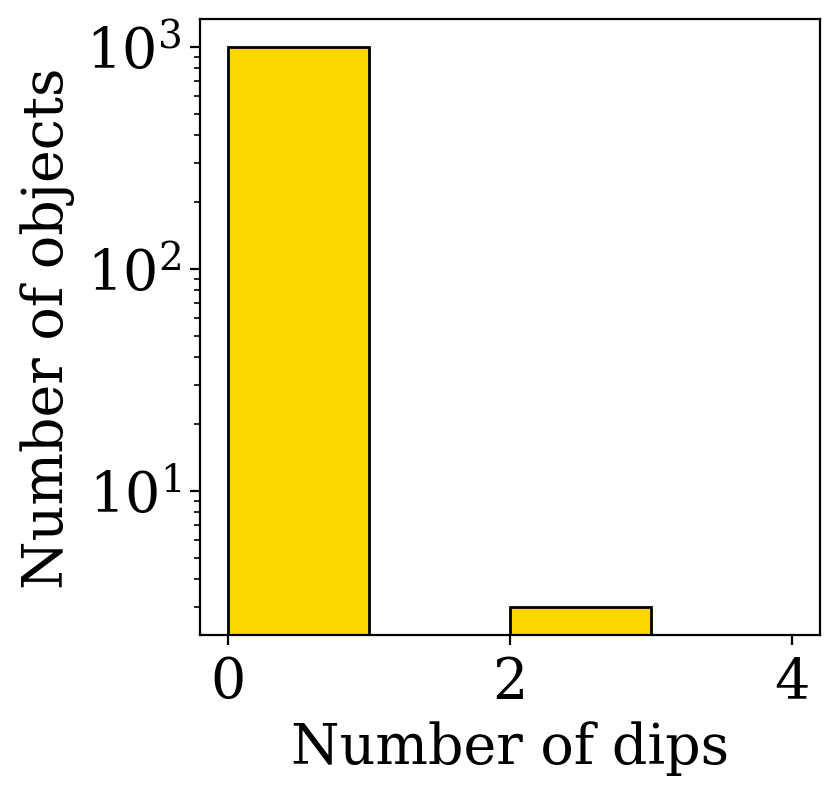

In [143]:
plt.figure(figsize=(4,4))
plt.hist(demo_table['Ndips'], bins=np.arange(0, 5, 1), color='gold', edgecolor='k')
plt.yscale('log')
plt.xlabel('Number of dips')
plt.ylabel('Number of objects')

In [170]:
demo_table[demo_table['Ndips']>1].head(5)

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,Norder,Dir,Npix,biweight_scale,frac_above_2_sigma,M_stat,Ndips,best_dip_power,best_dip_frac1sig,biweight_scale_2sig_in
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
3277879555129344,1636148068921376768,Gaia DR3 1638925160569600,1638925160569600,983991813,2016.0,43.200690,0.047812,2.977032,0.048395,0.590020,...,5,0,2,0.015866,0.004425,-0.254340,2.0,50.410980,1.0,0.013792
5158487424237568,1636148068921376768,Gaia DR3 2579218056222592,2579218056222592,1444854581,2016.0,47.628244,0.027508,3.552070,0.023517,1.582651,...,5,0,4,0.016559,0.007353,-0.227320,2.0,67.098557,2.0,0.014541
6981271968284672,1636148068921376768,Gaia DR3 3490610116387584,3490610116387584,1376143806,2016.0,46.458016,0.037841,4.409105,0.033552,0.728495,...,5,0,6,0.021565,0.036036,-0.963141,2.0,6.044022,5.0,0.018702


In [171]:
# can we query a light curve with more than 2 dips?
demo_table[demo_table['Ndips']>1].head(5)['ps1_objid_ztf_dr14']

_hipscat_index
3277879555129344    111570432006832885
5158487424237568    112260476281113012
6981271968284672    113290464579711435
Name: ps1_objid_ztf_dr14, dtype: int64

In [172]:
%%time
lc_tbl = _sources.cone_search(ra=46.458016, dec=4.409105, radius=0.01).query("ps1_objid_ztf_source == 113290464579711435").compute()


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 39.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 28 s, sys: 1.17 s, total: 29.2 s
Wall time: 31 s


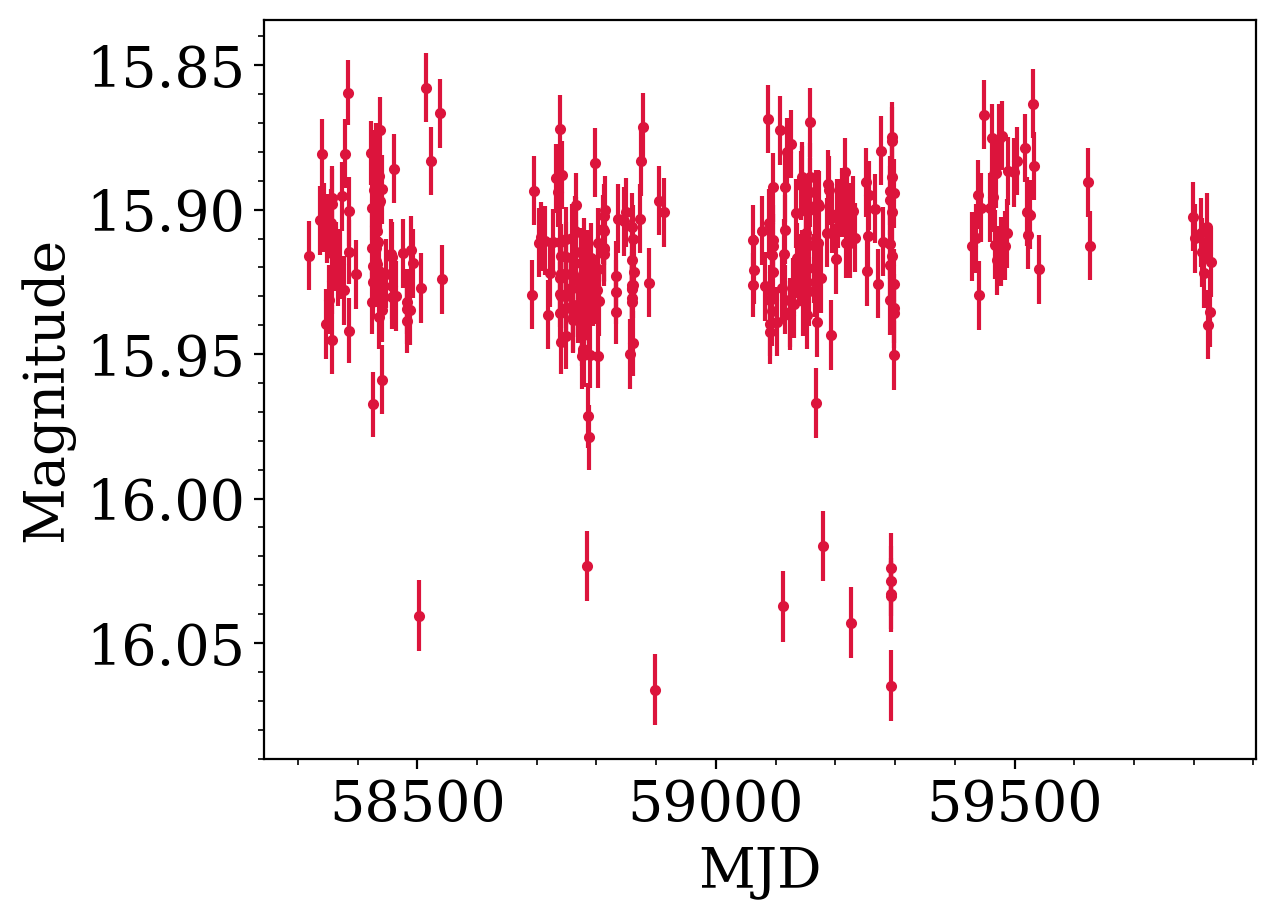

In [176]:
qq = (lc_tbl['band_ztf_source'] == 'r') & (lc_tbl['catflags_ztf_source'] == 0)

#import matplotlib.pyplot as plt
plt.errorbar(lc_tbl['mjd_ztf_source'][qq], lc_tbl['mag_ztf_source'][qq], yerr=lc_tbl['magerr_ztf_source'][qq], fmt='.',color='Crimson')
plt.gca().invert_yaxis()
plt.ylabel('Magnitude')
plt.xlabel('MJD')
plt.minorticks_on()

In [ ]:
# let's be brave and store object table?! ;o 

In [177]:
%%time
ens.object.to_parquet("ztf_source_dipper.parquet", engine='pyarrow')

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 6.18 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of 

In [1]:
import pandas as pd

In [3]:
%%time
tbl = pd.read_parquet("ztf_source_dipper.parquet")

CPU times: user 15min 47s, sys: 3min, total: 18min 47s
Wall time: 4min 20s


In [4]:
tbl

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,Norder,Dir,Npix,biweight_scale,frac_above_2_sigma,M_stat,Ndips,best_dip_power,best_dip_frac1sig,biweight_scale_2sig_in
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
4046484714712727552,1636148068921376768,Gaia DR3 2023242343069597952,2023242343069597952,1187857116,2016.0,288.284452,0.023692,23.356064,0.039220,0.658799,...,5,0,3594,0.016979,0.013559,-1.307430,0.0,0.0,0.0,0.014878
4046486996959363072,1636148068921376768,Gaia DR3 2023243476940991488,2023243476940991488,1800521875,2016.0,288.258786,0.028018,23.409952,0.045791,0.423252,...,5,0,3594,0.018802,0.014689,-1.186171,0.0,0.0,0.0,0.016737
4046487133567844352,1636148068921376768,Gaia DR3 2023243545660484096,2023243545660484096,1740121984,2016.0,288.221047,0.027828,23.402912,0.045091,0.370083,...,5,0,3594,0.045087,0.006780,-1.132424,0.0,0.0,0.0,0.040344
4046487622267174912,1636148068921376768,Gaia DR3 2023243786178629120,2023243786178629120,762038863,2016.0,288.282155,0.030046,23.414167,0.047130,0.323481,...,5,0,3594,0.019066,0.014673,-1.038199,0.0,0.0,0.0,0.016887
4046487883857526784,1636148068921376768,Gaia DR3 2023243923617581696,2023243923617581696,1230449605,2016.0,288.293525,0.027193,23.429098,0.043419,0.473504,...,5,0,3594,0.017289,0.015801,-1.053660,0.0,0.0,0.0,0.014930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041974552379523072,1636148068921376768,Gaia DR3 2020987274771960960,2020987274771960960,1256319968,2016.0,296.606656,0.035799,25.781349,0.050324,0.637235,...,5,0,3589,0.020618,0.026379,-1.208798,0.0,0.0,0.0,0.017734
4041974961848451072,1636148068921376768,Gaia DR3 2020987274771979136,2020987274771979136,1526546245,2016.0,296.597928,0.028961,25.789111,0.041997,0.655003,...,5,0,3589,0.031428,0.004779,-1.379389,0.0,0.0,0.0,0.028356
4041974737092476928,1636148068921376768,Gaia DR3 2020987343491438720,2020987343491438720,1673082801,2016.0,296.567967,0.027170,25.781454,0.039887,0.609629,...,5,0,3589,0.018234,0.021480,-1.210994,0.0,0.0,0.0,0.015793


Text(0, 0.5, 'Number of objects')

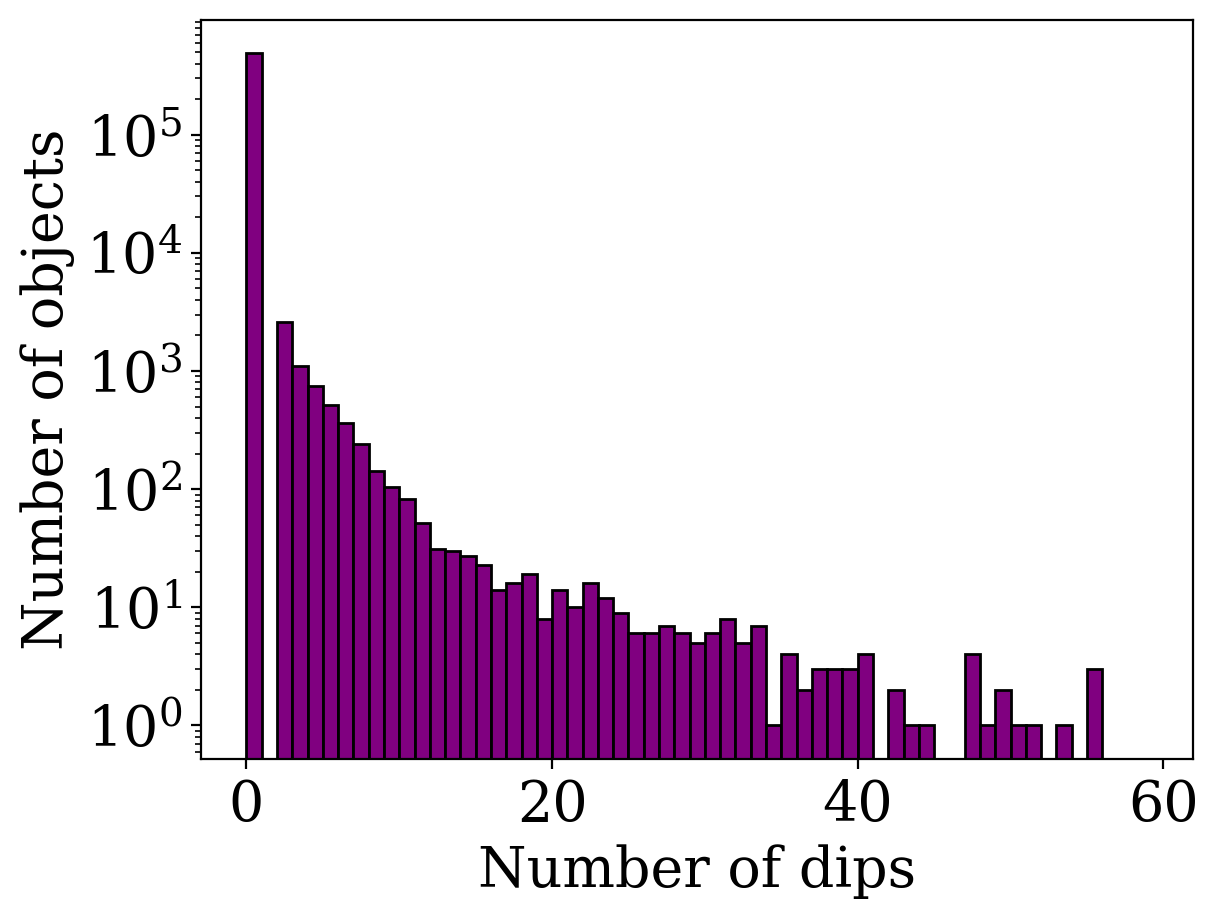

In [51]:
_ = plt.hist(tbl['Ndips'], bins=np.arange(0, 60, 1), color='purple', edgecolor='k', histtype='bar')

plt.yscale('log')
plt.xlabel('Number of dips')
plt.ylabel('Number of objects')

NameError: name 'tbl' is not defined

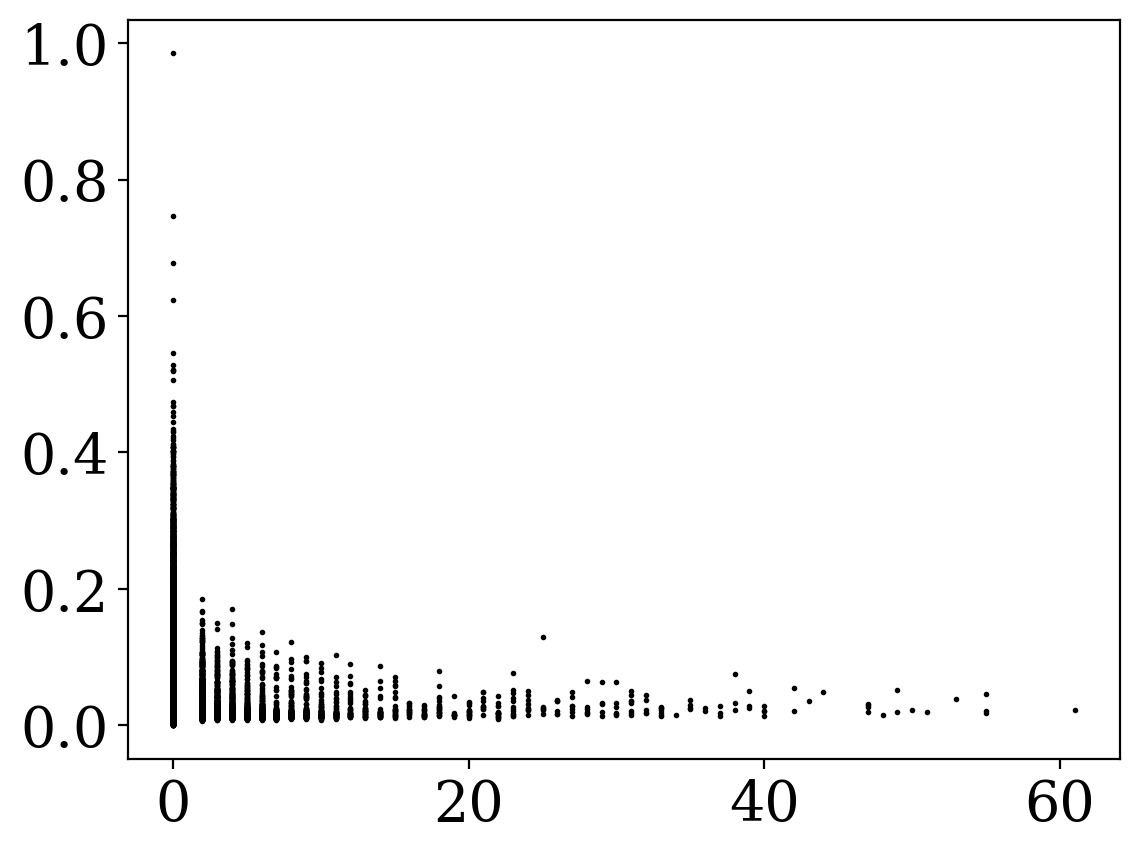

In [19]:
plt.scatter(tbl['Ndips'], (tbl['biweight_scale_2sig_in']), color='k', edgecolor='k', s=1)


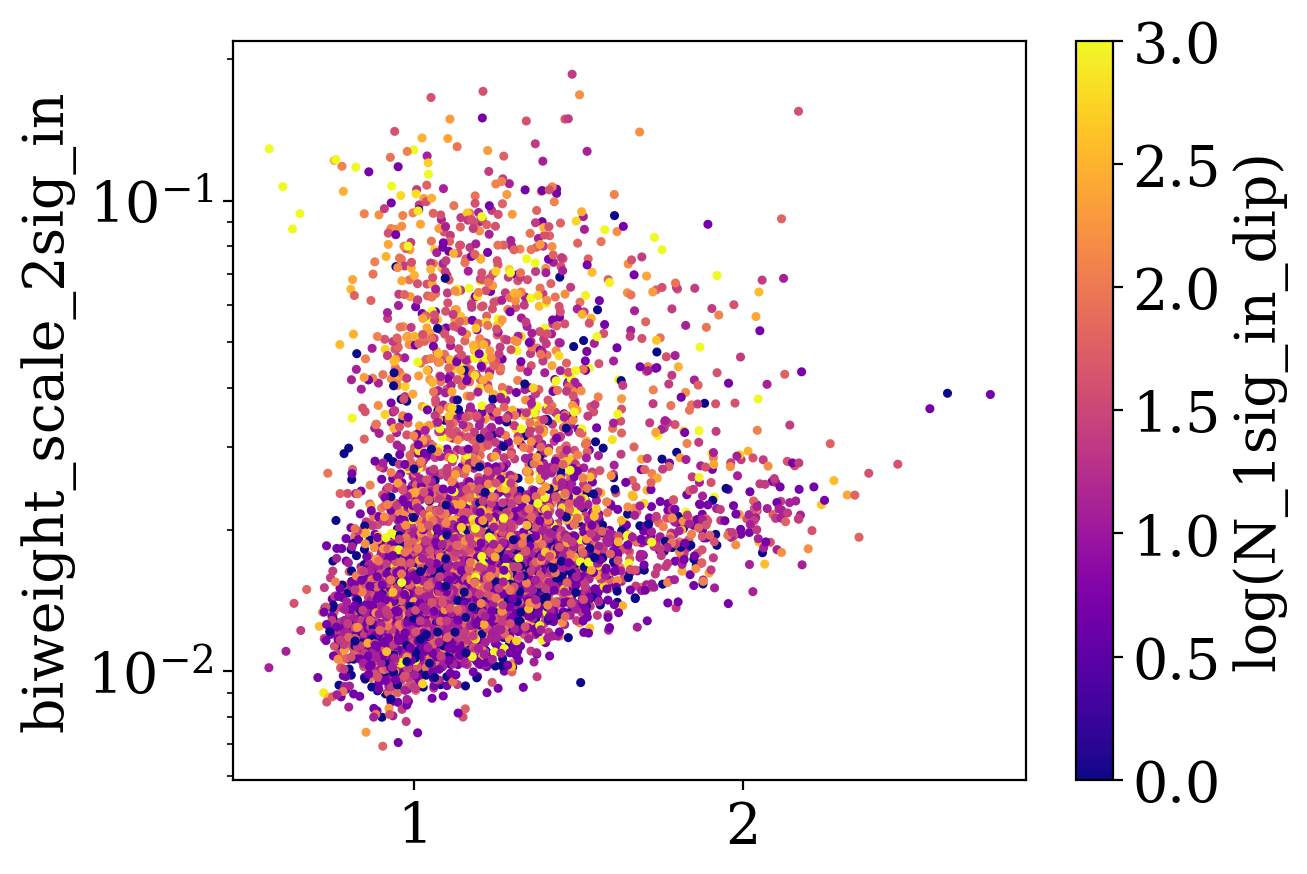

In [33]:
plt.scatter(tbl['bp_rp_gaia'], tbl['biweight_scale_2sig_in'], c=np.log(tbl['best_dip_frac1sig']), s=5.1, cmap='plasma', vmin=0, vmax=3)
plt.colorbar(label='log(N_1sig_in_dip)')
plt.ylabel('biweight_scale_2sig_in')
plt.yscale('log')